SparkAI: Predicting Electric Vehicle (EV) Range and Building a Generative AI Chatbot

This project addresses range anxiety experienced by electric vehicle (EV) users by developing an AI-driven system to accurately predict driving range. The model uses real-world factors including vehicle parameters, trip data, and environmental conditions for improved accuracy. Additionally, a generative AI-powered chatbot will provide users with clear, interactive explanations and tips about their vehicle’s performance and predicted range.

**STEP 1:** the focus is on building a robust machine learning model to predict the remaining driving range of electric vehicles (EVs). This involves data cleaning, feature engineering, and training an XGBoost regression model tuned for accuracy using real-world factors like vehicle specs, trip conditions, and environment data. The model is evaluated, interpreted via feature importance, and saved for deployment. This foundational step sets the stage for integrating with user-facing components in subsequent phases.

# File Upload Process

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ChargingBundles.csv to ChargingBundles.csv
Saving SyntheticTripsCanaryWharf.csv to SyntheticTripsCanaryWharf.csv
Saving SyntheticTripsWestfield.csv to SyntheticTripsWestfield.csv


# Data Cleaning and Feature Engineering Process

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df1 = pd.read_csv('ChargingBundles.csv')
df2 = pd.read_csv('SyntheticTripsCanaryWharf.csv')
df3 = pd.read_csv('SyntheticTripsWestfield.csv')
df = df1

print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nData Types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nSummary statistics (numerical):\n", df.describe())


num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())


cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

df_encoded = pd.get_dummies(df, columns=cat_cols)

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

if 'battery_capacity' in df_encoded.columns:
    df_encoded['battery_capacity_per_weight'] = df_encoded['battery_capacity'] / df_encoded.get('vehicle_weight', 1)

if 'speed' in df_encoded.columns and 'duration' in df_encoded.columns:
    df_encoded['estimated_distance'] = df_encoded['speed'] * df_encoded['duration']

if 'ac_usage' in df_encoded.columns:
    df_encoded['ac_usage'] = df_encoded['ac_usage'].apply(lambda x: 1 if x in ['Yes', 1, 'ON'] else 0)


if 'passengers' in df_encoded.columns and 'cargo_weight' in df_encoded.columns:
    df_encoded['total_load'] = df_encoded['passengers'] + df_encoded['cargo_weight']

print("\nData after cleaning, encoding, and feature engineering:\n")
print(df_encoded.head())
print("\nFinal columns:\n", df_encoded.columns)

df1.to_csv('ChargingBundles_modified.csv', index=False)
df2.to_csv('SyntheticTripsCanaryWharf_modified.csv', index=False)
df3.to_csv('SyntheticTripsWestfield_modified.csv', index=False)


Shape: (60, 7)

Columns:
 Index(['Unnamed: 0', 'Charging_Rate', 'Charging_FirstHour',
       'Charging_SecondHour', 'Charging_ThirdHour', 'Charging_FourthHour',
       'Parking'],
      dtype='object')

Data Types:
 Unnamed: 0             int64
Charging_Rate          int64
Charging_FirstHour     int64
Charging_SecondHour    int64
Charging_ThirdHour     int64
Charging_FourthHour    int64
Parking                int64
dtype: object

Missing values per column:
 Unnamed: 0             0
Charging_Rate          0
Charging_FirstHour     0
Charging_SecondHour    0
Charging_ThirdHour     0
Charging_FourthHour    0
Parking                0
dtype: int64

Summary statistics (numerical):
        Unnamed: 0  Charging_Rate  Charging_FirstHour  Charging_SecondHour  \
count   60.000000      60.000000           60.000000            60.000000   
mean    29.500000       4.633333            0.366667             0.566667   
std     17.464249       5.991425            0.485961             0.499717   
min     

**Saved the cleaned, encoded, and feature-engineered datasets to new CSV files**

In [ ]:
df1.to_csv('ChargingBundles_modified.csv', index=False)
df2.to_csv('SyntheticTripsCanaryWharf_modified.csv', index=False)
df3.to_csv('SyntheticTripsWestfield_modified.csv', index=False)


# Tuned XGBoost hyperparameters with GridSearchCV and evaluated using RMSE and MAE.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

X = df_encoded.drop('Charging_Rate', axis=1)
y = df_encoded['Charging_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Test RMSE:", rmse)
print("Test MAE:", mae)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Test RMSE: 1.3059900513402862
Test MAE: 1.0073328010252256


# Tuned XGBoost hyperparameters using RandomizedSearchCV with early stopping and evaluated using RMSE.


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=20, n_jobs=-1, random_state=42)

param_distributions = {
    "learning_rate": np.linspace(0.01, 0.2, 20),
    "subsample": np.linspace(0.5, 1.0, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6),
    "min_child_weight": [1, 3, 5, 7],
    "max_depth": list(range(3, 16)),
    "alpha": [0, 0.01, 1, 5, 10],
    "lambda": [0, 0.01, 1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

best_model = random_search.best_estimator_

print("Best hyperparameters:", random_search.best_params_)

y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best hyperparameters: {'subsample': np.float64(1.0), 'min_child_weight': 7, 'max_depth': 14, 'learning_rate': np.float64(0.02), 'lambda': 10, 'colsample_bytree': np.float64(0.9), 'alpha': 10}
Validation RMSE: 1.1792808017366307


# Performed a two-step train-test split for model training and evaluation.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 42
Validation set size: 9
Test set size: 9


# Trained an XGBoost regressor with early stopping on validation data and evaluated performance using RMSE and MAE metrics.


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('ChargingBundles_modified.csv')

if 'Parking' in df.columns:
    df['Parking'] = df['Parking'].astype('category')

X = df.drop('Charging_Rate', axis=1)
y = df['Charging_Rate']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.02,
    max_depth=14,
    n_estimators=1000,
    subsample=1.0,
    min_child_weight=7,
    colsample_bytree=0.9,
    reg_lambda=10,
    reg_alpha=10,
    early_stopping_rounds=20,
    enable_categorical=True,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

print("Best iteration:", model.best_iteration)
y_pred = model.predict(X_val, iteration_range=(0, model.best_iteration))
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")


[0]	validation_0-rmse:7.00960
[1]	validation_0-rmse:6.97156
[2]	validation_0-rmse:6.93411
[3]	validation_0-rmse:6.89723
[4]	validation_0-rmse:6.86091
[5]	validation_0-rmse:6.82515
[6]	validation_0-rmse:6.78994
[7]	validation_0-rmse:6.75527
[8]	validation_0-rmse:6.72113
[9]	validation_0-rmse:6.68752
[10]	validation_0-rmse:6.65443
[11]	validation_0-rmse:6.62186
[12]	validation_0-rmse:6.58979
[13]	validation_0-rmse:6.55822
[14]	validation_0-rmse:6.52714
[15]	validation_0-rmse:6.49655
[16]	validation_0-rmse:6.46643
[17]	validation_0-rmse:6.43679
[18]	validation_0-rmse:6.40762
[19]	validation_0-rmse:6.40880
[20]	validation_0-rmse:6.38009
[21]	validation_0-rmse:6.38117
[22]	validation_0-rmse:6.35292
[23]	validation_0-rmse:6.32512
[24]	validation_0-rmse:6.29776
[25]	validation_0-rmse:6.27083
[26]	validation_0-rmse:6.24433
[27]	validation_0-rmse:6.24503
[28]	validation_0-rmse:6.21895
[29]	validation_0-rmse:6.19330
[30]	validation_0-rmse:6.16805
[31]	validation_0-rmse:6.14320
[32]	validation_0-

# Visualized feature importance to interpret model decisions.

Test RMSE: 1.565379274619088
Test MAE: 1.168146014213562
Feature Importances:
Unnamed: 0: 2277.0
Charging_SecondHour: 182.0
Charging_FourthHour: 171.0
Charging_FirstHour: 166.0
Charging_ThirdHour: 102.0
Parking: 11.0


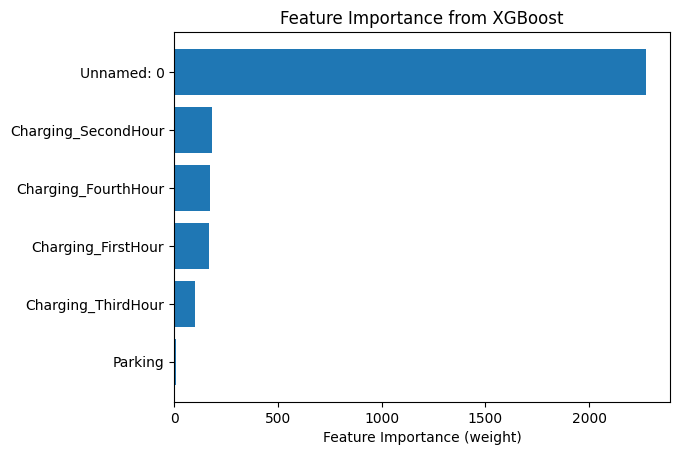

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_test_pred = model.predict(X_test, iteration_range=(0, model.best_iteration))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

print("Feature Importances:")
for feature, score in sorted_importance.items():
    print(f"{feature}: {score}")

plt.barh(list(sorted_importance.keys()), list(sorted_importance.values()))
plt.xlabel("Feature Importance (weight)")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()


# Saved the trained model

In [ ]:
model.save_model('model.json')
import xgboost as xgb

loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')


FUTURE WORK

**STEP 2:** Focuses on integrating a generative AI-powered chatbot into the system to enhance user interaction and accessibility. The chatbot enables EV users to ask natural language questions about their vehicle’s range and performance predictions. It provides clear, personalized explanations and practical driving tips, improving user confidence and reducing range anxiety. The chatbot will be deployed via a user-friendly interface such as a Streamlit web app, allowing real-time conversational support and seamless integration with the predictive model backend.

**STEP 3:** Deploying the trained AI model and chatbot as an integrated web or mobile application that provides real-time EV range predictions and interactive user support.